# Preprocess data 

### Loading data and dependencies

In [17]:
import numpy as np
import pandas as pd
import re
import json
import os
from collections import defaultdict

# Display imports
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.5)

# Audio imports
import librosa
from tqdm import tqdm
import time


In [18]:
data_dir = "../sample_data"
json_file_path = os.path.join(data_dir, "generate_sampledata/audio/podcasts_info.json")
transcription_dir = os.path.join(data_dir, "generate_sampledata/transcribe_assemblyai/transcript_output/")
audio_dir = os.path.join(data_dir, "generate_sampledata/audio/audio_output/")

with open(json_file_path, 'r') as j:
    podcast_info = json.loads(j.read())

### Cleaning the data

In [19]:
def check_english(column_list):
    """
    Checks if the dataset does not contain any non-english characters
    """
    column_list = [title.replace(" ", "") for title in column_list]
    column_list = [re.sub(r'[^\w\s]', '', title) for title in column_list]
    column_list = [title.lower() for title in column_list]
    is_english = [bool(re.match("^[A-Za-z0-9]*$", title)) for title in column_list]
    return is_english
    
start_len = len(podcast_info)
print("original length of df: ", start_len)

# Convert to df
df = pd.DataFrame(podcast_info)
df = df[['show_title', 'producer', 'genre', 'description', 'num_episodes',
                               'rating', 'num_reviews',  'title', 'link', 'url', 'id', 'itunes_channel_id']]

# Drop rows if cells are used in this notebook
used_cols = ["show_title", "producer", "genre", "description", "num_episodes", "title", "id", "itunes_channel_id"]
df = df.replace('NA', np.nan)
df = df.dropna(subset=used_cols)
df = df.dropna()

# Check if titles and description are using english alphabet
df_titles = list(df['title'])
df_descr = list(df['description'])
english_titles = check_english(df_titles)
english_descr = check_english(df_descr)
is_english = np.logical_and(english_titles, english_descr)

# Drop podcasts that contain non-english alphabetical words
df['is_english'] = is_english
df = df[df.is_english == True]
df = df.drop(columns=['is_english'])

end_len = len(df)
display(df.head(2))
print("final length of df after cleaning: ", end_len)


original length of df:  2569


,show_title,producer,genre,description,num_episodes,rating,num_reviews,title,link,url,id,itunes_channel_id
0,Medic2Medic Podcast,Steven Cohen,Health & Fitness,"Medic2Medic Podcast is for EMTs, Paramedics, E...",255.0,4.3,25.0,Bob Farrow,https://podcasts.apple.com/us/podcast/id107240...,https://api.spreaker.com/download/episode/1214...,6280b3c4-2f42-4838-8fec-b5711622c7cb,1072403751
1,Medic2Medic Podcast,Steven Cohen,Health & Fitness,"Medic2Medic Podcast is for EMTs, Paramedics, E...",255.0,4.3,25.0,Josh Stuart,https://podcasts.apple.com/us/podcast/id107240...,https://api.spreaker.com/download/episode/1203...,fb9c2ce7-f77f-4a5c-b992-7f4e243dc647,1072403751


final length of df after cleaning:  2161


### Add audio statistics

In [21]:

# Add duration of each audiofile to df
ids = df['id'].to_numpy()

durations = []
for count, show_id in enumerate(ids):
    try:
        filepath = audio_dir + show_id + ".wav"
        secs = librosa.get_duration(filename=filepath)
        durations.append(secs)
    except:
        print("File missing: ", count, filepath)
        raise
        
df['duration'] = durations

### Load AssemblyAI transcriptions

In [27]:

all_transcriptions = []

count = 0
for subdir, dirs, files in os.walk(transcription_dir):
    for file in files:
        filename, ext = file.rsplit(".", 1)

        # Transcribe all wav files
        if ext == "json":
            
            # Read transcription
            filepath = os.path.join(subdir, file)
            with open(filepath) as json_file:
                trans_dict = json.load(json_file)
                
            # Confidence of transcription
            confidence = trans_dict["confidence"]
            
            # Transcribed text
            text = trans_dict["text"]
            txtlen = len(text)
            
            # Set of speakers
            utterances = trans_dict["utterances"]
            speakers = set([d['speaker'] for d in utterances])
    
            is_not_unk = lambda x: x != "UNK"
            num_speakers = len(list(filter(is_not_unk, speakers)))

            this_transcription = {}
            this_transcription['id'] = filename
            this_transcription['confidence'] = confidence
            this_transcription['text'] = text
            this_transcription['txtlen'] = txtlen
            this_transcription['speakers'] = speakers
            this_transcription['num_speakers'] = num_speakers
            all_transcriptions.append(this_transcription)
            count += 1
            

transcript_df = pd.DataFrame(all_transcriptions)
display(transcript_df.head(2))

print("Number of transcribed podcasts: ", len(transcript_df))



,id,confidence,text,txtlen,speakers,num_speakers
0,267eadab-7c08-440b-81f8-79b1d77faece,0.869588,"From the Verongo Casino Studios. It's Frosty, ...",17176,"{C, A, B}",3
1,f3c3b8c9-e316-400d-b61f-1af52828481a,0.901593,Win A Pageant episode 112 Beauty Truth and Gra...,26002,"{C, B, A, UNK}",3


Number of transcribed podcasts:  175


In [28]:
# Add the transcriptions to the merged df
trans_df = pd.merge(df, transcript_df, on="id", how="outer")
trans_df = trans_df.dropna()
print(len(trans_df))
display(trans_df.head(5))

175


,show_title,producer,genre,description,num_episodes,rating,num_reviews,title,link,url,id,itunes_channel_id,duration,confidence,text,txtlen,speakers,num_speakers
2,Phonographic Memory,Phonographic Memory,Music,Phonographic Memory is a storytelling project ...,21.0,5.0,47.0,"Episode 16: Will Georgantas & the Mysterious ""...",https://podcasts.apple.com/us/podcast/id107623...,http://media.blubrry.com/phonographicmemory/co...,3768ce88-2a9e-4499-a5d2-a5cfde26d855,1076237390,903.314375,0.909298,"This is Phonographic Memory, a storytelling pr...",9129.0,"{C, B, A}",3.0
17,Under the Radar,Relay FM,Technology,From development and design to marketing and s...,231.0,4.6,171.0,Under the Radar 87: Old Code Vs. New APIs,https://podcasts.apple.com/us/podcast/id105568...,http://www.podtrac.com/pts/redirect.mp3/traffi...,52a8613d-ce9d-4dd6-9a26-4781e4ff475e,1055685246,1774.445750,0.907207,"Welcome to under the Radar, a show about indep...",28567.0,"{B, A}",2.0
18,Under the Radar,Relay FM,Technology,From development and design to marketing and s...,231.0,4.6,171.0,Under the Radar 85: iOS 11,https://podcasts.apple.com/us/podcast/id105568...,http://www.podtrac.com/pts/redirect.mp3/traffi...,ef375654-8bce-4a4f-8d5c-02bd6314d1f5,1055685246,1787.506875,0.900494,"Welcome to under the Radar, a show about indep...",27560.0,"{A, B}",2.0
26,Anne of Avonlea by Lucy Maud Montgomery,Books Should Be Free,Kids & Family,If you've read and loved Anne of Green Gables ...,30.0,4.4,26.0,03 - Mr. Harrison at Home,https://podcasts.apple.com/us/podcast/id866411980,http://www.archive.org/download/anne_avonlea_1...,e1caa09f-9572-4bed-a361-c30cbf84967e,866411980,777.743500,0.903550,Chapter Three of Anne of Avonlee by Lucy Maud ...,13044.0,"{B, A}",2.0
27,Anne of Avonlea by Lucy Maud Montgomery,Books Should Be Free,Kids & Family,If you've read and loved Anne of Green Gables ...,30.0,4.4,26.0,04 - Different Opinions,https://podcasts.apple.com/us/podcast/id866411980,http://www.archive.org/download/anne_avonlea_1...,14b3f7e0-3053-4ef4-a4a8-96a8351f4fae,866411980,559.934500,0.913662,Chapter Four of Anne of Avonleigh by Lucy Modm...,8959.0,"{C, D, A, E, B}",5.0


### Save preprocessed data

All preprocessing is now done, lets save the dataframes. 
> - df is cleaned by removing all NaN and non-english
> - df_clean also dropped podcasts longer than 30 minutes or shorter than 5 minutes
> - trans_df contains all transcriptions

In [29]:

print("Saving cleaned data")
print("length: ", len(df))
cleaned_data_path = os.path.join(data_dir, "sample_data_cleaned.pkl")
df.to_pickle(cleaned_data_path)

print("Saving transcribed data")
print("length: ", len(trans_df))
transcribed_data_path = os.path.join(data_dir, "sample_data_transcribed.pkl")
trans_df.to_pickle(transcribed_data_path)


Saving cleaned data
length:  2161
Saving transcribed data
length:  175


### Assign chunks to create AssemblyAI transcriptions
### (Skip this - continue at "Data analysis")
This is a bit hacky, but for now assemblyAI can only process 300 minutes for free for each account. Therefore I need to create a df that assigns chunks of data of 300 minutes. 

The output of this part of the notebook is used by the transciptions in the folder /transcribe_assembly/. 
Run the files in that folder immediately after this cell

In [30]:
# Load which data was already assigned a chunk
last_chunked_data_path = os.path.join(data_dir, "sample_data_chunked.pkl")
df_chunked_last = pd.read_pickle(last_chunked_data_path)

# Drop all podcasts longer than 30 minutes or shorter than 5 minutes
max_duration = 60 * 30
min_duration = 60 * 5
print(len(df))

df_chunked = df.copy()
df_chunked = df_chunked[df_chunked.duration <= max_duration]
df_chunked = df_chunked[df_chunked.duration >= min_duration]

df_chunked = df_chunked.merge(df_chunked_last[["id", "chunks"]], on="id", how = 'outer')
display(df_chunked.tail(1))

print(len(df_chunked))

2161


,show_title,producer,genre,description,num_episodes,rating,num_reviews,title,link,url,id,itunes_channel_id,duration,chunks
615,Real Estate Investing Classroom (Audio): Exper...,Mike Hambright & Flipnerd.com,Business,The FlipNerd Real Estate Investing Classroom p...,738.0,4.9,51.0,Lesson #593: Ways to Handle Requests for Proof...,https://podcasts.apple.com/us/podcast/id105589...,http://traffic.libsyn.com/reiclassroomaudio/Le...,0744d502-1b09-40e4-914b-8b89a241bf9f,1055893340,552.04575,39.0


616


In [31]:
# Since AssemblyAI allows for submitting 300 minutes at once, lets
# Subdivide the dataset in chunks of max 300 minutes
chunks = []
cur_chunk = df_chunked['chunks'].max()
print("Starting adding chunks from ", cur_chunk)

curchunk_duration = 0
maxchunk_duration = 300 * 60 # Minutes * seconds
# maxchunk_duration = 3 * 60 # Minutes * seconds

count = 0
for index, row in df_chunked.iterrows():
    duration = row['duration']

    # If the cell has not yet been assigned a chunk
    if pd.isnull(row['chunks']) or row['chunks'] == -1.0:
        count += 1
        curchunk_duration += duration

        if duration > maxchunk_duration:
            print("duration limit")
            raise
            chunks.append(-1)

        elif curchunk_duration < maxchunk_duration:
            chunks.append(cur_chunk)
        else:
            cur_chunk += 1
            chunks.append(cur_chunk)
            curchunk_duration = duration
    else:
        chunks.append(row['chunks'])

df_chunked['chunks'] = chunks

display(df_chunked.head(2))
display(df_chunked.tail(2))
print("Assinged {} new chunks".format(count))
print("len of df: ", len(df_chunked))
if count > 0:
    print("Updated chunks")
    df_chunked.to_pickle(last_chunked_data_path)
print("done")

Starting adding chunks from  39.0


,show_title,producer,genre,description,num_episodes,rating,num_reviews,title,link,url,id,itunes_channel_id,duration,chunks
0,Phonographic Memory,Phonographic Memory,Music,Phonographic Memory is a storytelling project ...,21.0,5.0,47.0,"Episode 16: Will Georgantas & the Mysterious ""...",https://podcasts.apple.com/us/podcast/id107623...,http://media.blubrry.com/phonographicmemory/co...,3768ce88-2a9e-4499-a5d2-a5cfde26d855,1076237390,903.314375,0.0
1,Under the Radar,Relay FM,Technology,From development and design to marketing and s...,231.0,4.6,171.0,Under the Radar 87: Old Code Vs. New APIs,https://podcasts.apple.com/us/podcast/id105568...,http://www.podtrac.com/pts/redirect.mp3/traffi...,52a8613d-ce9d-4dd6-9a26-4781e4ff475e,1055685246,1774.445750,0.0


,show_title,producer,genre,description,num_episodes,rating,num_reviews,title,link,url,id,itunes_channel_id,duration,chunks
614,Real Estate Investing Classroom (Audio): Exper...,Mike Hambright & Flipnerd.com,Business,The FlipNerd Real Estate Investing Classroom p...,738.0,4.9,51.0,Lesson #594: Determining Accurate Spreads,https://podcasts.apple.com/us/podcast/id105589...,http://traffic.libsyn.com/reiclassroomaudio/Le...,4061404b-e3a8-4d23-91f0-18cdab06dddf,1055893340,355.918375,39.0
615,Real Estate Investing Classroom (Audio): Exper...,Mike Hambright & Flipnerd.com,Business,The FlipNerd Real Estate Investing Classroom p...,738.0,4.9,51.0,Lesson #593: Ways to Handle Requests for Proof...,https://podcasts.apple.com/us/podcast/id105589...,http://traffic.libsyn.com/reiclassroomaudio/Le...,0744d502-1b09-40e4-914b-8b89a241bf9f,1055893340,552.045750,39.0


Assinged 0 new chunks
len of df:  616
done


In [32]:
print("Saving chunked data")
print("length: ", len(df_chunked))
df_chunked.to_pickle(last_chunked_data_path)

Saving chunked data
length:  616


# Data analysis


In [33]:
import numpy as np
import pandas as pd
import re
import json
import os
from collections import defaultdict, Counter
from pathlib import Path

# Display imports
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.5)

In [34]:
data_dir = "../sample_data"
json_file_path = os.path.join(data_dir, "generate_sampledata/audio/podcasts_info.json")
transcription_dir = os.path.join(data_dir, "generate_sampledata/transcribe_assemblyai/transcript_output/")
audio_dir = os.path.join(data_dir, "generate_sampledata/audio/audio_output/")

figures_dir = "figures/"
Path(figures_dir).mkdir(parents=True, exist_ok=True)

In [35]:
print("Loading cleaned data")
cleaned_data_path = os.path.join(data_dir, "sample_data_cleaned.pkl")
df = pd.read_pickle(cleaned_data_path)
print("length: ", len(df))

print("Loading chunked data")
df_chunked = pd.read_pickle(last_chunked_data_path)
print("length: ", len(df_chunked))

print("Loading transcribed data")
transcribed_data_path = os.path.join(data_dir, "sample_data_transcribed.pkl")
trans_df = pd.read_pickle(transcribed_data_path)
print("length: ", len(trans_df))

Loading cleaned data
length:  2161
Loading chunked data
length:  616
Loading transcribed data
length:  175


### Shows vs Episodes

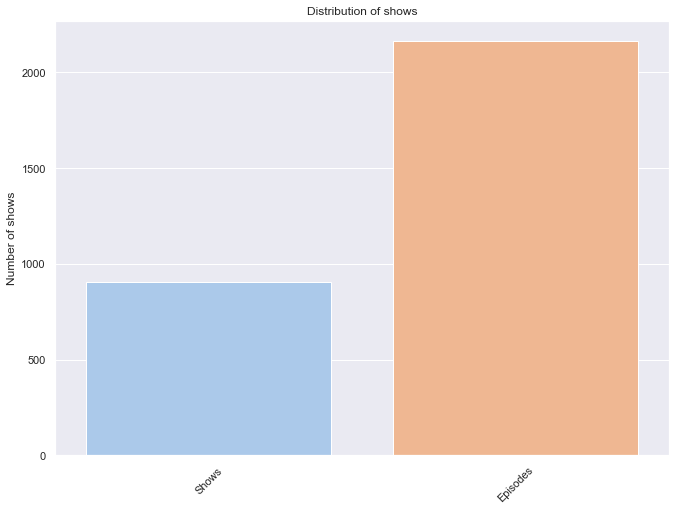

In [39]:
# Set plotting options
sns.set(rc={'figure.figsize':(11, 8)})
palette = sns.color_palette('muted')
palette = sns.color_palette('pastel')

unique_episodes = df['id'].nunique()
unique_shows = df['itunes_channel_id'].nunique()

# Show barplot
plt.title("Distribution of shows")
plt.ylabel("Number of shows")

plt.xticks(rotation=45)
sns.barplot(x=["Shows", "Episodes"], y=[unique_shows, unique_episodes], palette=palette)
plt.show()

# TODO: verdeling van episodes per show (als in df)


### Duration

Total duration 6414419 seconds 106907 minutes 
Mean duration 2968 seconds 49 minutes 


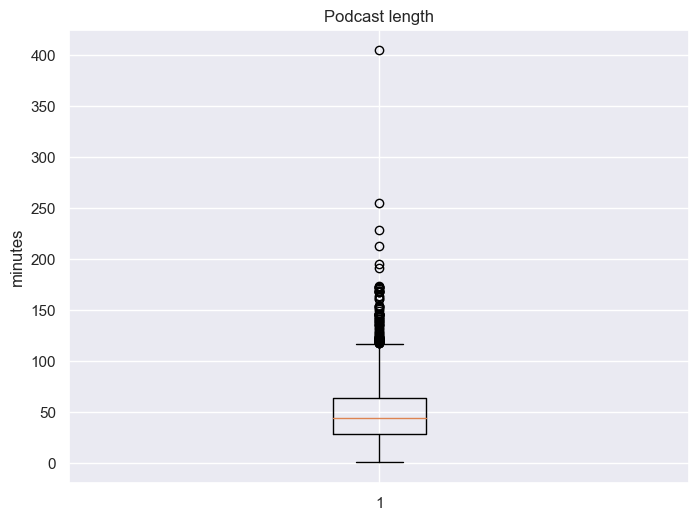

In [40]:
df['duration'] = durations
print("Total duration {:0.0f} seconds {:0.0f} minutes ".format(df['duration'].sum(), df['duration'].sum()/60))
print("Mean duration {:0.0f} seconds {:0.0f} minutes ".format(df['duration'].mean(), df['duration'].mean()/60))

fig1, ax1 = plt.subplots(figsize=(8, 6), dpi=100)
ax1.set_title('Podcast length')
ax1.boxplot(df['duration']/60)
plt.ylabel('minutes')
plt.show()

### Number of reviews

In [41]:
genre = df[['genre', 'rating', 'num_reviews']]
genre.groupby('genre').mean().sort_values('num_reviews', ascending=[False])

,rating,num_reviews
genre,,
True Crime,4.590000,5206.600000
Comedy,4.749587,1188.884298
Fiction,4.750000,502.850000
Education,4.612195,474.886179
History,4.644444,464.962963
Business,4.706316,443.971930
Arts,4.725281,378.123596
News,4.610000,377.700000
Sports,4.594554,319.920792


### Genre

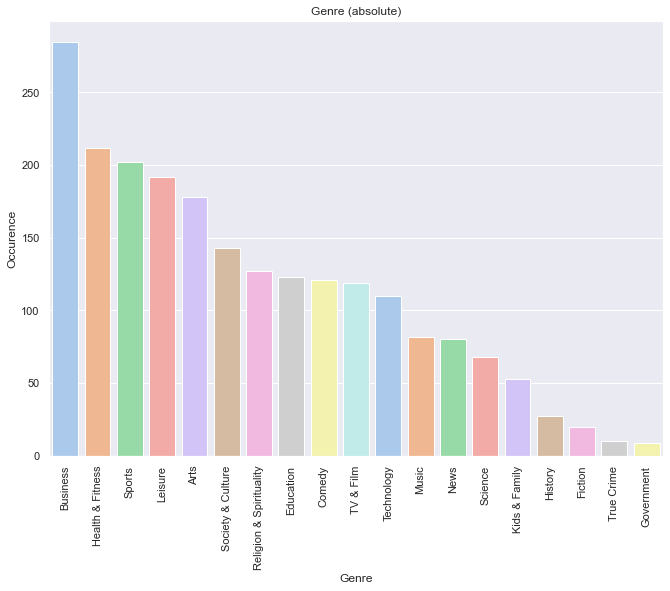

In [42]:
genre_names = df['genre'].value_counts().index
genre_values = df['genre'].value_counts().values


# Show barplot
plt.title("Genre (absolute)")
plt.ylabel("Occurence")
plt.xlabel("Genre")
plt.xticks(rotation=90)
sns.barplot(x=genre_names, y=genre_values, palette=palette)
plt.show()

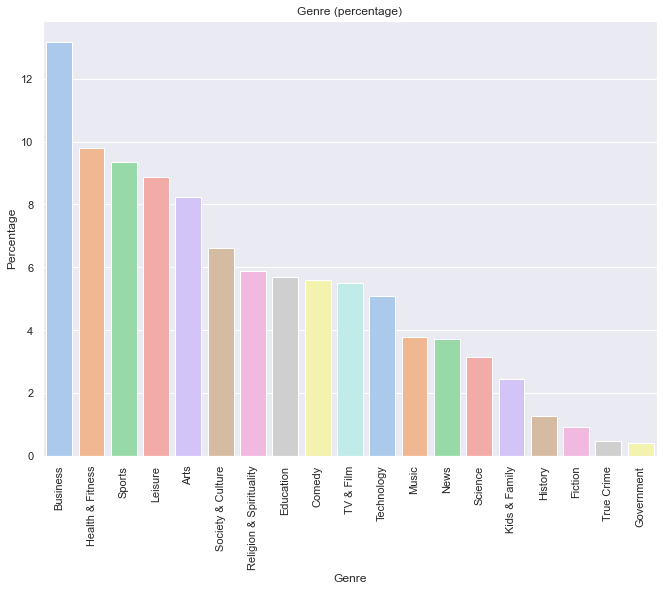

In [43]:
## Zelfde maar dan in percentages
genre_values_perc = genre_values / np.sum(genre_values) * 100

plt.title("Genre (percentage)")
plt.ylabel("Percentage")
plt.xlabel("Genre")
plt.xticks(rotation=90)
sns.barplot(x=genre_names, y=genre_values_perc, palette=palette)
plt.show()



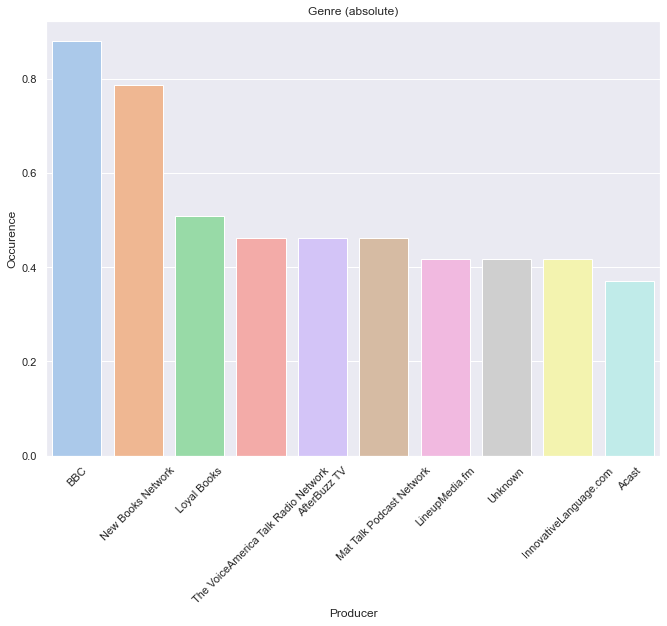

In [44]:
# Top 10 producers
producers = df['producer'].value_counts().index
producers_values = df['producer'].value_counts().values
producers_values_perc = producers_values / np.sum(producers_values) * 100

# Show barplot
plt.title("Genre (absolute)")
plt.ylabel("Occurence")
plt.xlabel("Producer")
plt.xticks(rotation=45)
sns.barplot(x=producers[:10], y=producers_values_perc[:10], palette=palette)
plt.show()



In [45]:
from stop_words import get_stop_words

def get_pod_stopwords():
    stop = get_stop_words('en')
    
    other = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
            'january', 'february', 'march', 'april', 'may', 'june', 
            'july', 'august', 'september', 'october', 'november', 'december',
            'nan', 'podcast', 'podcasts', 'every', 'new', 'weekly', 
            'stories', 'story', 'episode', 'episodes', 'listen', 
            'host', 'hosted', 'join', 'ep', 'e', 's', 'se', 'nd', 'part', 'show']
    stopwords = stop + other
    return stopwords

def clean(list_of_words):
    return [re.sub(r'([^\s\w]|_)+', '', x) for x in list_of_words]


def full_clean(dataframe):
    # Remove symbols
    dataframe = dataframe.map(lambda x: re.sub(r'([^\s\w]|_)+', '', x))
    
    # Remove numbers
    dataframe = dataframe.map(lambda x: re.sub(r'([0-9])+', '', x))
    
    
    # Lowercase everything
    dataframe = dataframe.str.lower()
    
    # Remove stopwords
    stop = get_pod_stopwords()
    stop = clean(stopwords)
    dataframe = dataframe.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return dataframe
    
# Get a list of podcast-specific stop-words
stopwords = get_pod_stopwords()
# stopwords = get_stop_words('en')

# remove non-alphanumeric, non-space
stopwords = clean(stopwords)

# Clean the text of the df
display(trans_df.head(2))
trans_df["text_cleaned"] = full_clean(trans_df["text"])
display(trans_df.head(2))

,show_title,producer,genre,description,num_episodes,rating,num_reviews,title,link,url,id,itunes_channel_id,duration,confidence,text,txtlen,speakers,num_speakers
2,Phonographic Memory,Phonographic Memory,Music,Phonographic Memory is a storytelling project ...,21.0,5.0,47.0,"Episode 16: Will Georgantas & the Mysterious ""...",https://podcasts.apple.com/us/podcast/id107623...,http://media.blubrry.com/phonographicmemory/co...,3768ce88-2a9e-4499-a5d2-a5cfde26d855,1076237390,903.314375,0.909298,"This is Phonographic Memory, a storytelling pr...",9129.0,"{B, A, C}",3.0
17,Under the Radar,Relay FM,Technology,From development and design to marketing and s...,231.0,4.6,171.0,Under the Radar 87: Old Code Vs. New APIs,https://podcasts.apple.com/us/podcast/id105568...,http://www.podtrac.com/pts/redirect.mp3/traffi...,52a8613d-ce9d-4dd6-9a26-4781e4ff475e,1055685246,1774.445750,0.907207,"Welcome to under the Radar, a show about indep...",28567.0,"{B, A}",2.0


,show_title,producer,genre,description,num_episodes,rating,num_reviews,title,link,url,id,itunes_channel_id,duration,confidence,text,txtlen,speakers,num_speakers,text_cleaned
2,Phonographic Memory,Phonographic Memory,Music,Phonographic Memory is a storytelling project ...,21.0,5.0,47.0,"Episode 16: Will Georgantas & the Mysterious ""...",https://podcasts.apple.com/us/podcast/id107623...,http://media.blubrry.com/phonographicmemory/co...,3768ce88-2a9e-4499-a5d2-a5cfde26d855,1076237390,903.314375,0.909298,"This is Phonographic Memory, a storytelling pr...",9129.0,"{B, A, C}",3.0,phonographic memory storytelling project dedic...
17,Under the Radar,Relay FM,Technology,From development and design to marketing and s...,231.0,4.6,171.0,Under the Radar 87: Old Code Vs. New APIs,https://podcasts.apple.com/us/podcast/id105568...,http://www.podtrac.com/pts/redirect.mp3/traffi...,52a8613d-ce9d-4dd6-9a26-4781e4ff475e,1055685246,1774.445750,0.907207,"Welcome to under the Radar, a show about indep...",28567.0,"{B, A}",2.0,welcome radar independent ios app development ...


In [46]:
## Most used words
#### REmove duplicate words by combining all episode titles
shows_df = df.copy()

# Get a df with all episode titles per show
title_list = shows_df.groupby('show_title')['title'].apply(list)

# Get all show titles
unique_shows = shows_df['show_title'].unique()

# Show descr + titles of all episodes
all_titles = {}
for show in unique_shows:
    all_titles[show] = ' '.join(title_list[show])
shows_df["all_titles"] = shows_df["show_title"].apply(lambda x: all_titles.get(x))
shows_df = shows_df.drop_duplicates(subset=['show_title'])
# display(shows_df)


# Clean all text
# Merge all text into new col
cols = ['show_title', 'description', 'all_titles']
shows_df['all_titles'] = shows_df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
shows_df["all_titles_cleaned"] = full_clean(shows_df["all_titles"])
display(shows_df.head(4))

[print(len(shows_df))]

,show_title,producer,genre,description,num_episodes,rating,num_reviews,title,link,url,id,itunes_channel_id,duration,all_titles,all_titles_cleaned
0,Medic2Medic Podcast,Steven Cohen,Health & Fitness,"Medic2Medic Podcast is for EMTs, Paramedics, E...",255.0,4.3,25.0,Bob Farrow,https://podcasts.apple.com/us/podcast/id107240...,https://api.spreaker.com/download/episode/1214...,6280b3c4-2f42-4838-8fec-b5711622c7cb,1072403751,2416.066375,Medic2Medic Podcast Medic2Medic Podcast is for...,medicmedic medicmedic emts paramedics ems lead...
2,Phonographic Memory,Phonographic Memory,Music,Phonographic Memory is a storytelling project ...,21.0,5.0,47.0,"Episode 16: Will Georgantas & the Mysterious ""...",https://podcasts.apple.com/us/podcast/id107623...,http://media.blubrry.com/phonographicmemory/co...,3768ce88-2a9e-4499-a5d2-a5cfde26d855,1076237390,903.314375,Phonographic Memory Phonographic Memory is a s...,phonographic memory phonographic memory storyt...
3,Cannabusiness Solutions,Cannabis Radio,Business,Teaching Canna-Business owners how to effectiv...,9.0,3.7,3.0,Cannabis Investing with Francis Priznar of Arc...,https://podcasts.apple.com/us/podcast/id118121...,http://api.spreaker.com/download/episode/10486...,5497c442-f7c8-4e83-a9a5-a5e93afdc909,1181210021,2101.526000,Cannabusiness Solutions Teaching Canna-Busines...,cannabusiness solutions teaching cannabusiness...
7,RAIDER LIFE PODCAST,Raider Life Podcast,Sports,Raider Life is an Independently owned podcast ...,97.0,5.0,31.0,Charlie Chat #20 | Gerald Riggs Pro Bowl RB Sp...,https://podcasts.apple.com/us/podcast/id107440...,http://feeds.soundcloud.com/stream/328023234-r...,ff6b6554-ef44-470f-b81c-98ea39c6d4a7,1074401499,2952.594375,RAIDER LIFE PODCAST Raider Life is an Independ...,raider life raider life independently owned li...


903


[None]

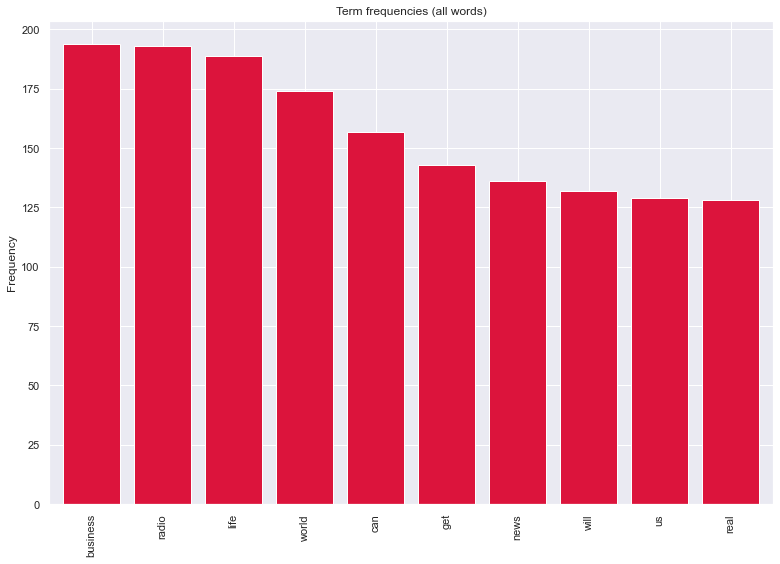

In [47]:

def get_tf(column, k=3):
    tf = Counter()
    column.str.split().apply(tf.update)
    
    most_common = sorted(tf, key=tf.get, reverse=True)[:k]

    return most_common, tf
    
    
def plot_tf(most_common_words, tf, title_spec=""):
    name = "Term frequencies ({})".format(title_spec)
    y = [tf[x] for x in most_common_words]
    plt.bar(most_common_words, y, color='crimson')
    plt.title(name)
    plt.ylabel("Frequency")
    # plt.yscale('log') # optionally set a log scale for the y-axis
    plt.xticks(rotation=90)
    plt.xlim(-0.6, len(most_common_words)-0.4) 
    plt.tight_layout() 
    plt.savefig("figures/{}.jpg".format(name))
    plt.show()

most_common_words, tf = get_tf(shows_df['all_titles_cleaned'], k=10)
plot_tf(most_common_words, tf, title_spec="all words")







Health & Fitness


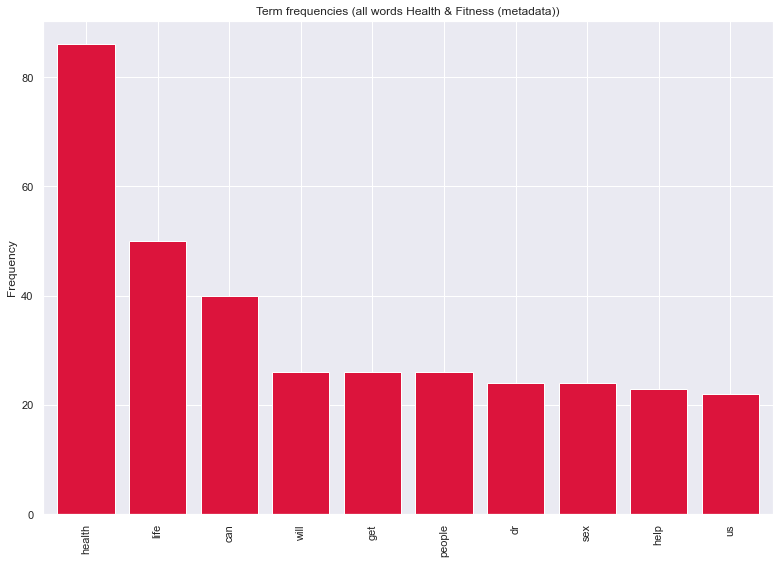

Music


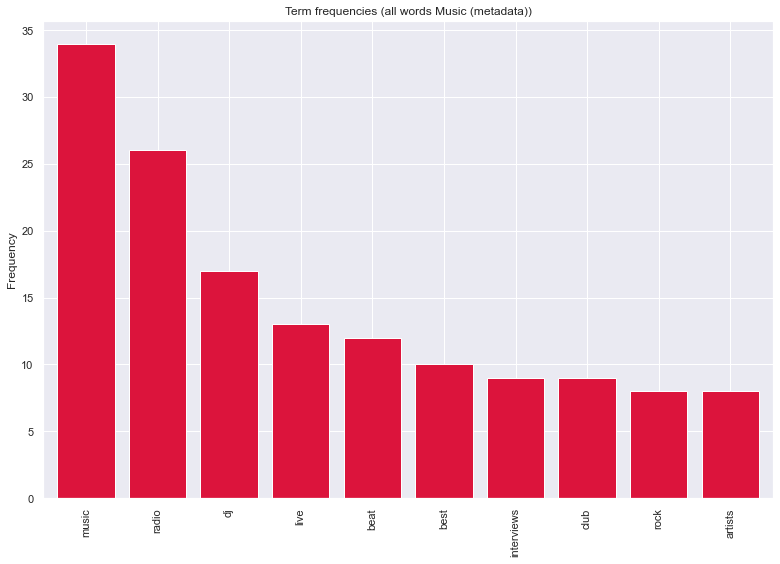

Business


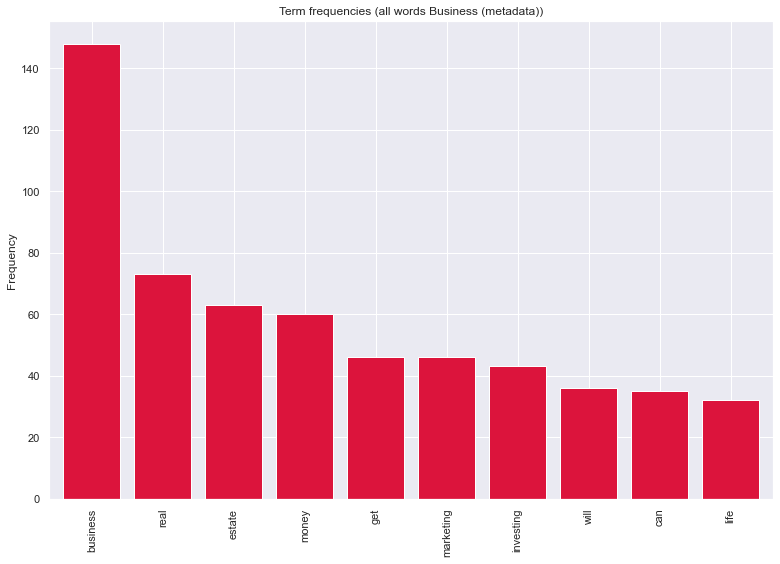

Sports


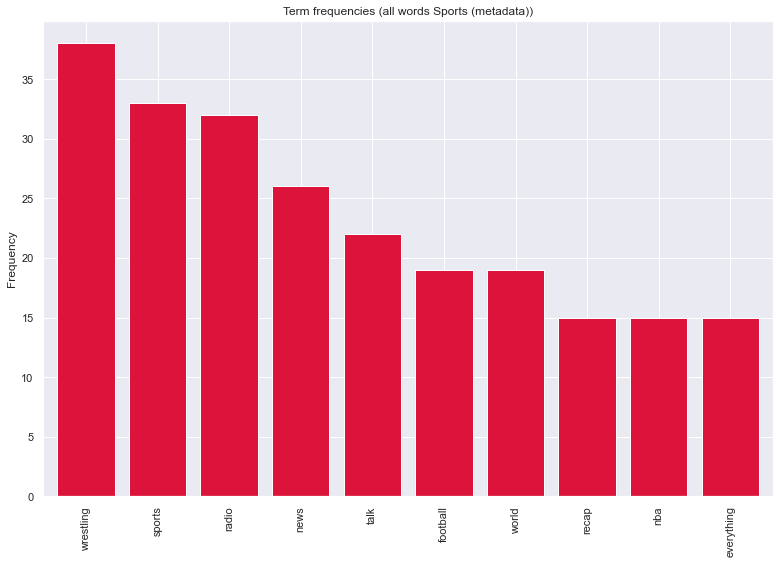

Arts


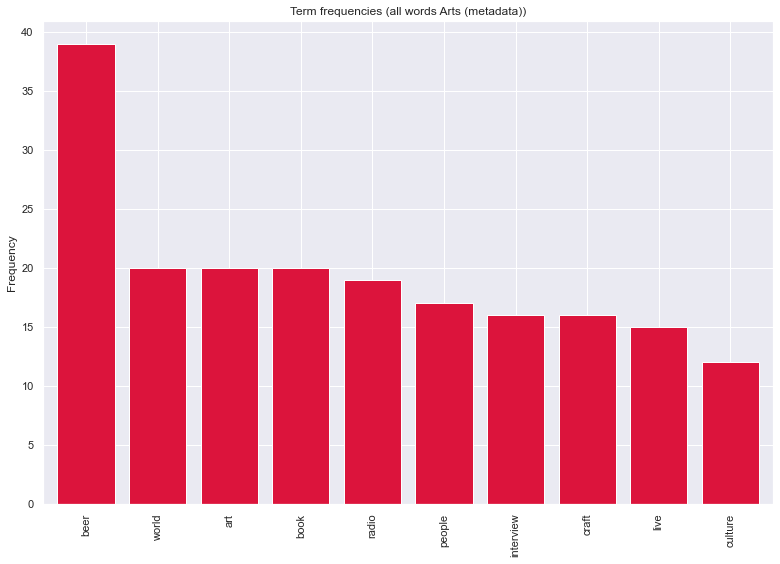

TV & Film


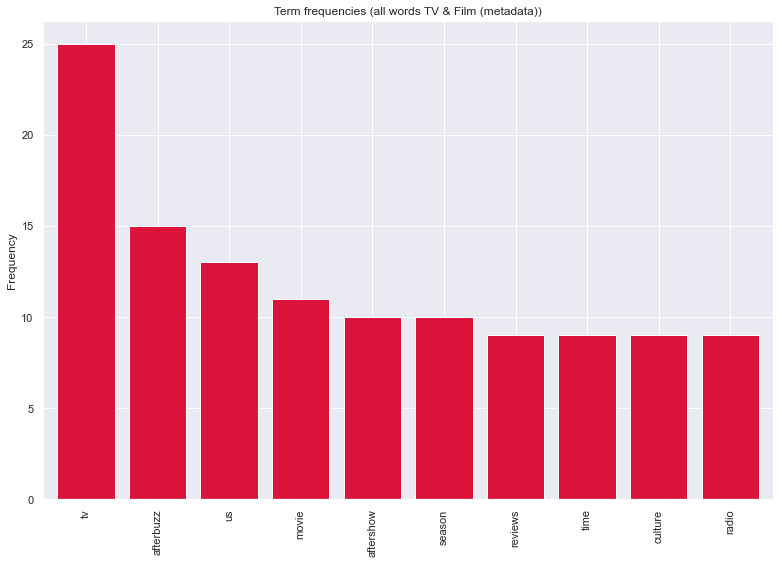

Technology


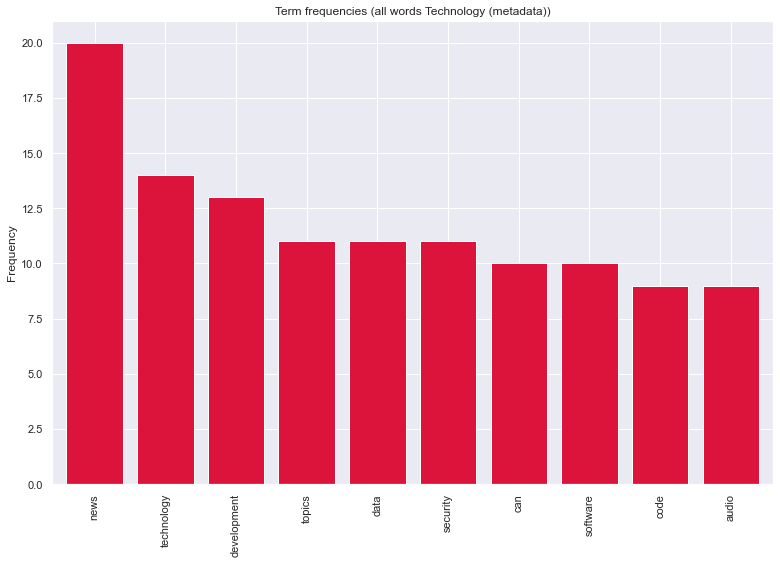

True Crime


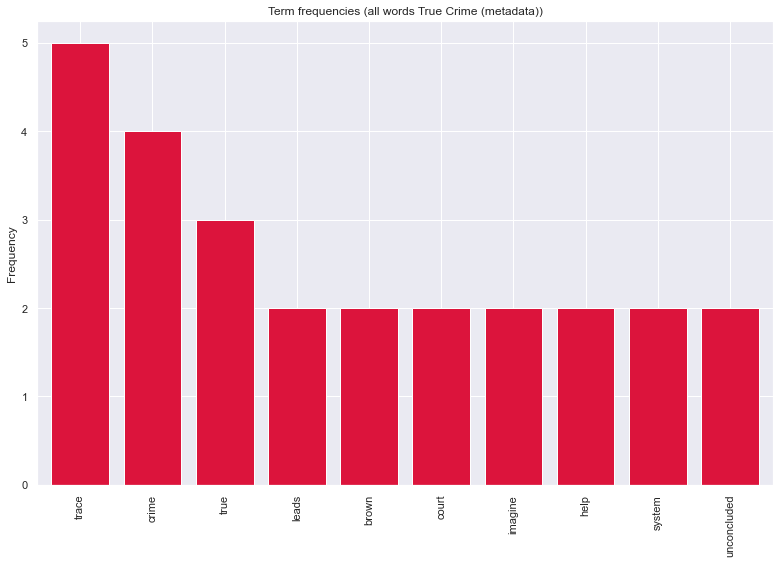

Kids & Family


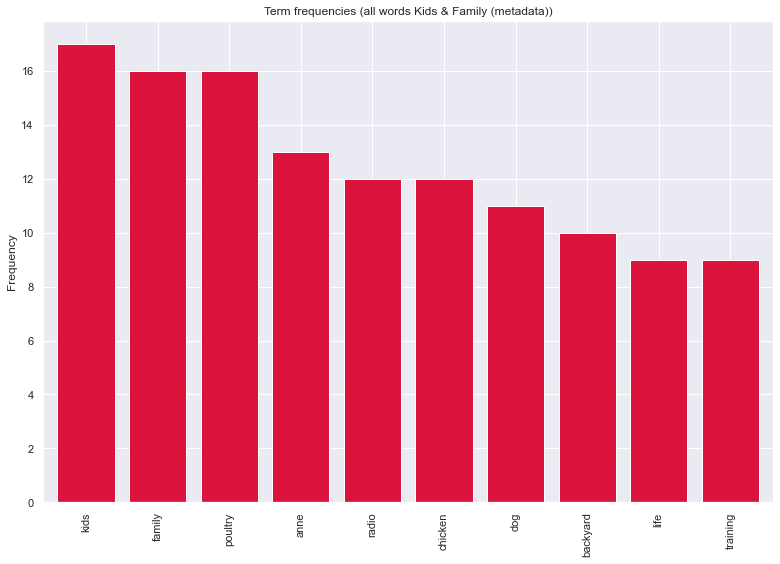

Society & Culture


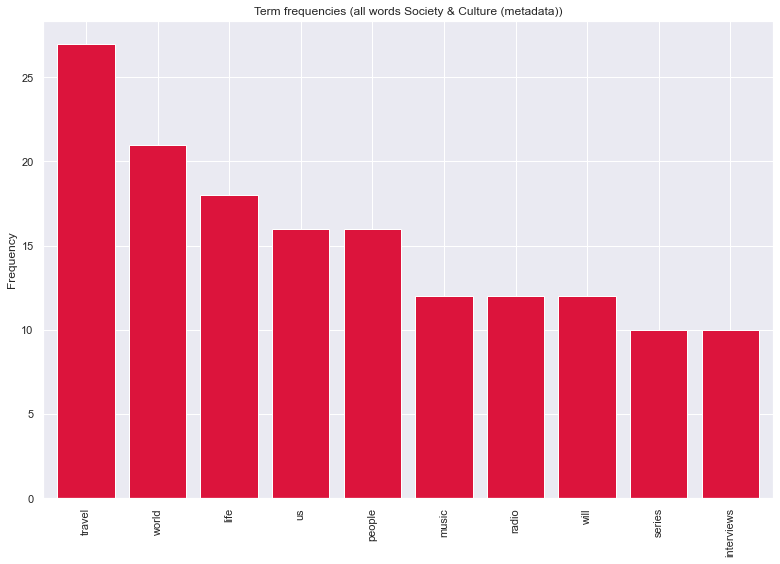

Leisure


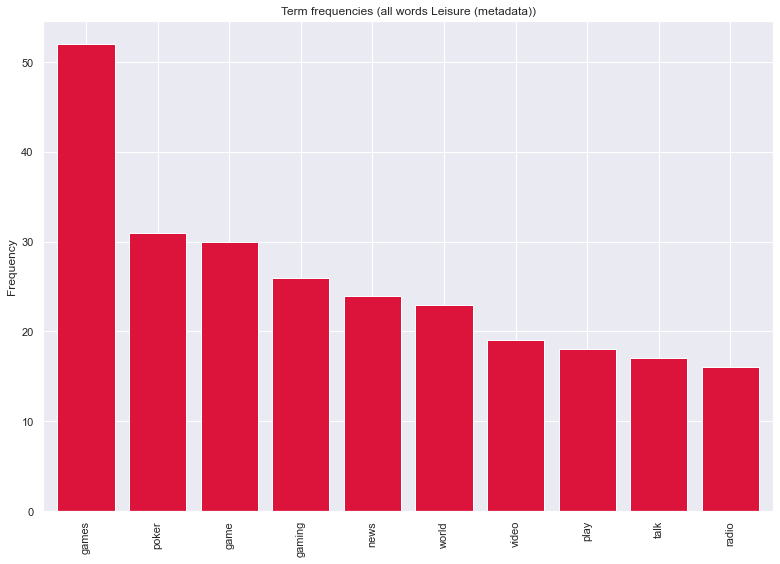

Comedy


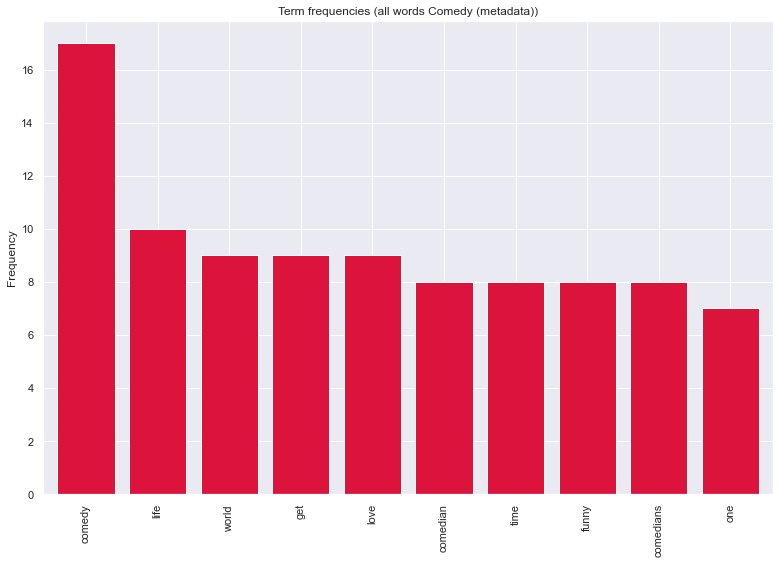

Religion & Spirituality


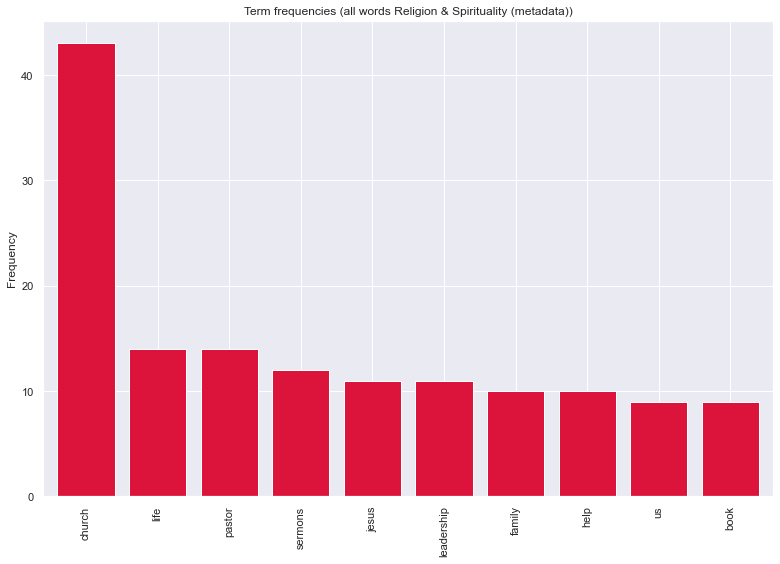

Education


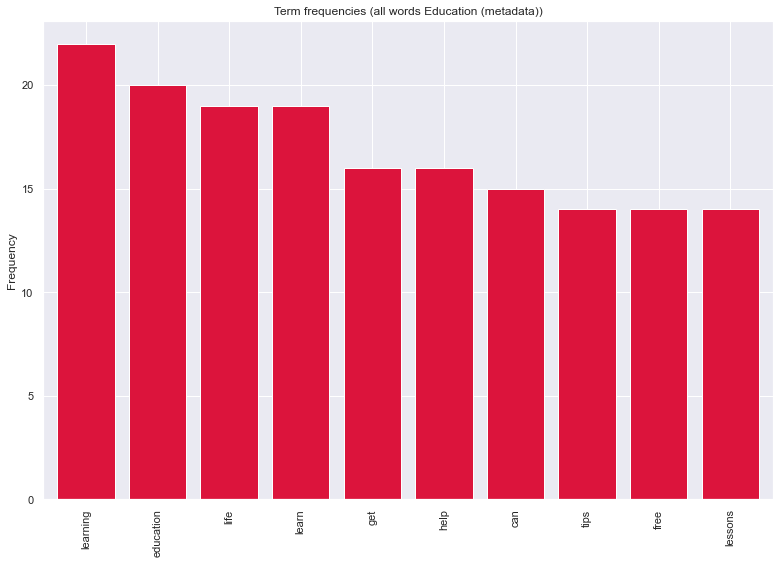

History


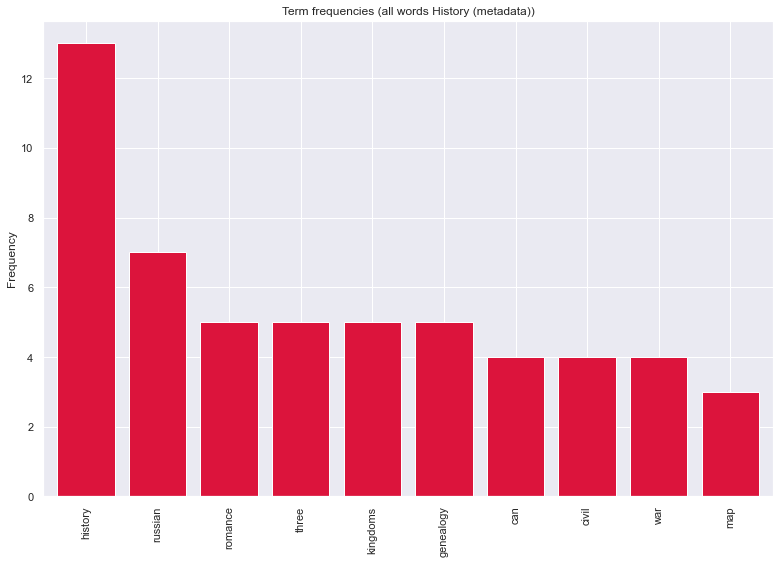

Fiction


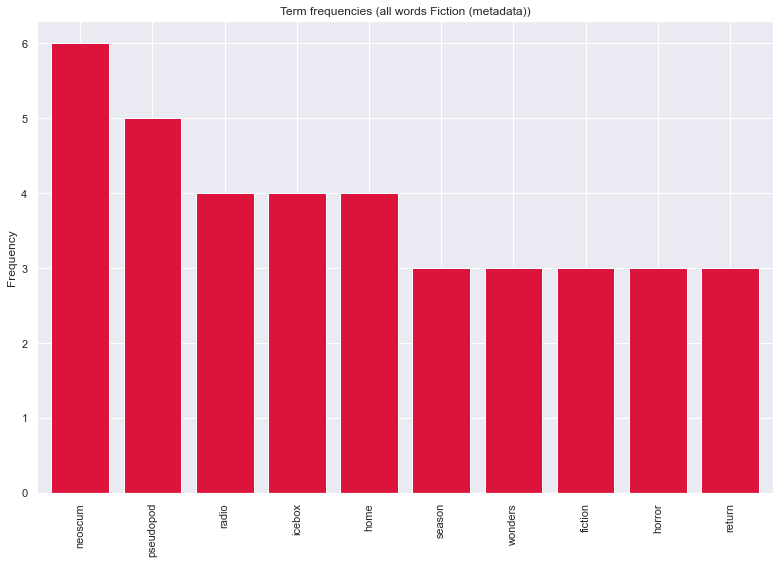

News


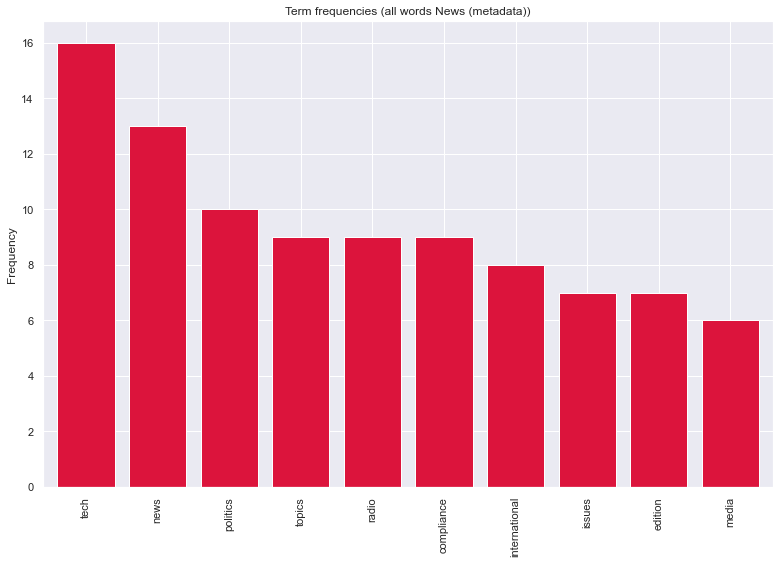

Science


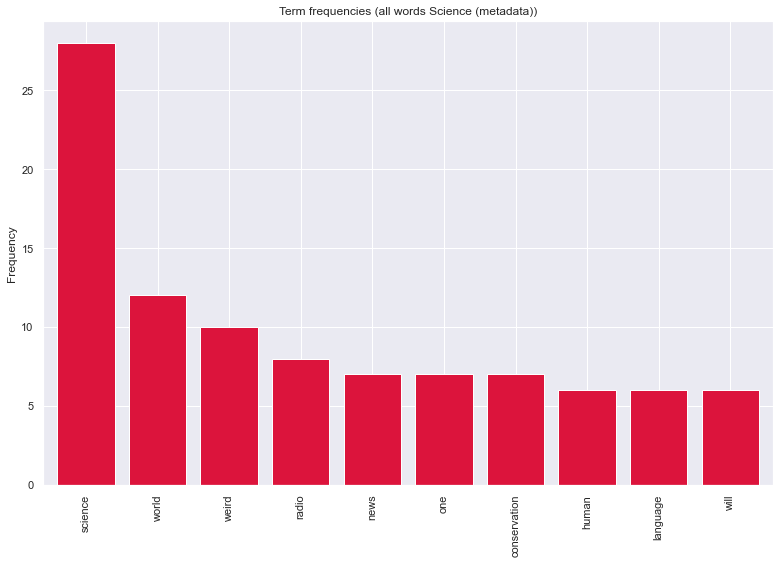

Government


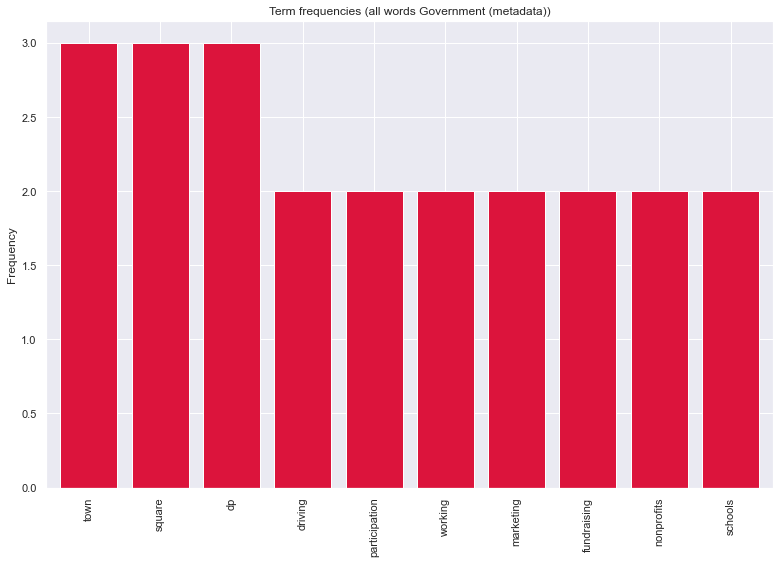

In [48]:
genres = shows_df['genre'].unique()

for genre in genres:
    print(genre)
    tmp = shows_df[shows_df['genre'] == genre]
    most_common_words, tf = get_tf(tmp['all_titles_cleaned'], k=10)
    plot_tf(most_common_words, tf, title_spec="all words {} (metadata)".format(genre))
    

In [45]:

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

GloVe_embedding_path = '../embeddings/glove/glove.6b.50d.txt'

def porter_stemmer(s):
    """
    Stemming (cut off suffixes)
    """
    tokens = word_tokenize(s)
    stem_s = ' '.join([ps.stem(token) for token in tokens])
    return stem_s
    

def lemmatization(s):
    """
    Lemmatization (take context into account)
    """
    tokens = word_tokenize(s)
    lem_s = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lem_s



def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_embedding = load_glove_model(GloVe_embedding_path)
    


Loading Glove Model
400000 words loaded!


In [46]:
## Cosine similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.spatial import distance

def get_cosine(s1, s2, method="wordcount", embeds=None):
    
    if method == "wordcount":
        # Count occurences of each token and put it in a document-term matrix
        vectorizer = CountVectorizer()
        sentence_list = [lemmatization(s1) , lemmatization(s2)]
        doc_term_matrix = vectorizer.fit_transform(sentence_list)
        
        # Create vectors with count of each word
        vec1 = doc_term_matrix.toarray()[0]
        vec2 = doc_term_matrix.toarray()[1]
        
    elif method == "tfidf":
        # Count tfidf of each token and put it in a document-term matrix
        vectorizer = TfidfVectorizer()
        sentence_list = [lemmatization(s1) , lemmatization(s2)]
        doc_term_matrix = vectorizer.fit_transform(sentence_list)
        
        # Create vectors with tf of each word
        vec1 = doc_term_matrix.toarray()[0]
        vec2 = doc_term_matrix.toarray()[1]
        
    elif method == "glove":
        if embeds:
            # Create tokens
            tokens1 = list(set(word_tokenize(s1)))
            tokens2 = list(set(word_tokenize(s2)))
            
            # Lookup tokens in embedding
            embedded1 = [embeds[t] for t in tokens1 if t in embeds]
            embedded2 = [embeds[t] for t in tokens2 if t in embeds]

            # Create vectors with embedding of all words
            vec1 = np.mean(embedded1, axis=0)
            vec2 = np.mean(embedded2, axis=0)
        else:
            print("No embeddings specified!")
            raise

    # Measure similarity
    cosine = distance.cosine(vec1, vec2)
    cosine_sim = (1-cosine)
    return cosine_sim


s1 = "This is just a sentence about love and angels!!! And even more. Much more inconvincible."
s2 = "This is just a angry shout about death. Nice."

print(get_cosine(s1, s1))
print(get_cosine(s1, s2))
print(get_cosine(s1, s1, method="tfidf"))
print(get_cosine(s1, s2, method="tfidf"))
print(get_cosine(s1, s1, method="glove", embeds=glove_embedding))
print(get_cosine(s1, s2, method="glove", embeds=glove_embedding))


1
0.33333333333333326
1
0.20608363501393823
1
0.96992234817223


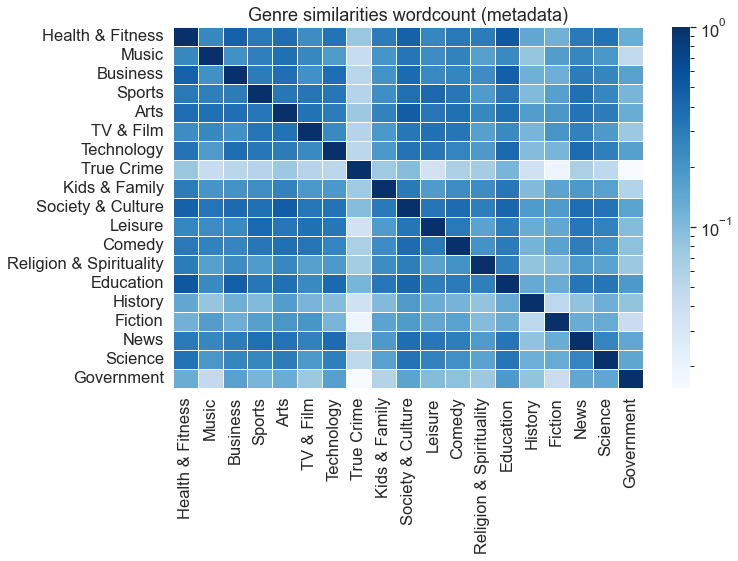

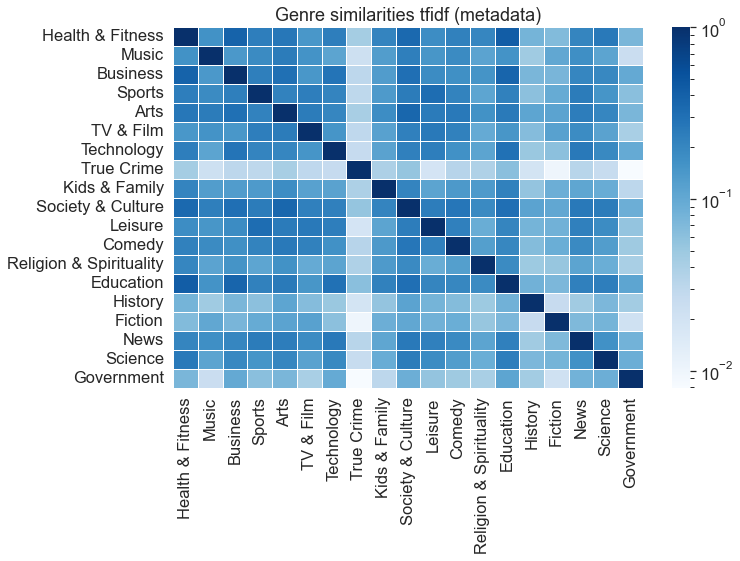

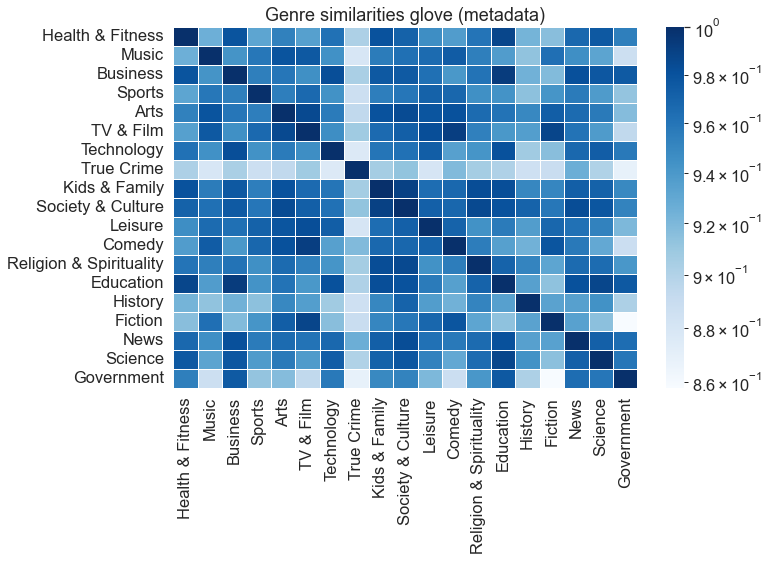

In [47]:
# Cosine similarity between genres

from matplotlib.colors import LogNorm, Normalize
sns.set(font_scale = 1.5)


def plot_heatmap(results, labels, method="wordcount", title_spec=""):
    ax = sns.heatmap(results, linewidth=0.5,  
                xticklabels=labels, yticklabels=labels,
                cmap="Blues", norm=LogNorm())

    name = "Genre similarities {} ({})".format(method, title_spec)
    ax.figure.tight_layout()
    plt.title(name, fontsize=18)
    plt.savefig('figures/{}.pdf'.format(name))
    plt.show()
    

def genre_similarity(dataframe, textcol,  method, title_spec="", embeds=None):

    genres = dataframe['genre'].unique()
    results = np.zeros((len(genres), len(genres)))

    for this_idx, genre in enumerate(genres):

        this_genre = dataframe[dataframe['genre'] == genre]
        this_text = ' '.join(this_genre[textcol].tolist())
        for other_idx, genre in enumerate(genres):
            other_genre = dataframe[dataframe['genre'] == genre]
            other_text = ' '.join(other_genre[textcol].tolist())

            sim = get_cosine(this_text, other_text, method=method, embeds=embeds)
            results[this_idx][other_idx] = sim

    plot_heatmap(results, genres, method, title_spec)
    return results


results = genre_similarity(shows_df, textcol="all_titles_cleaned", method="wordcount", title_spec="metadata")
results = genre_similarity(shows_df, textcol="all_titles_cleaned", method="tfidf", title_spec="metadata")
results = genre_similarity(shows_df, textcol="all_titles_cleaned", method="glove", title_spec="metadata", embeds=glove_embedding)



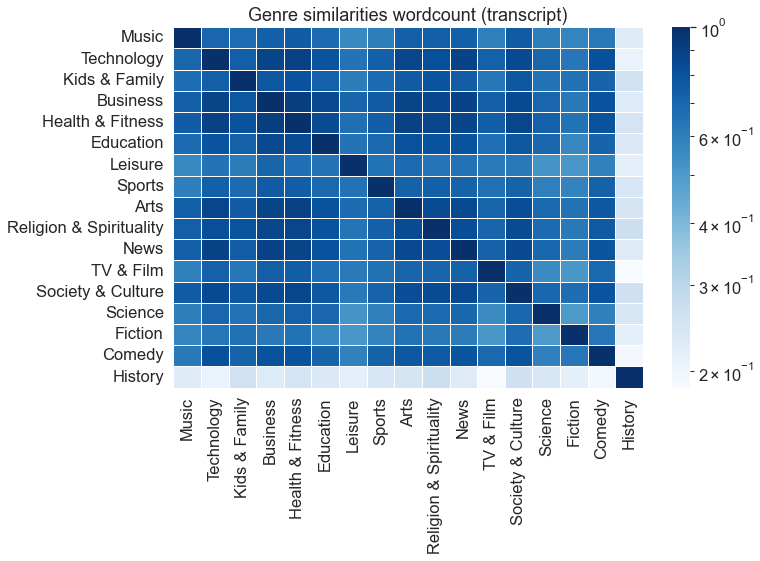

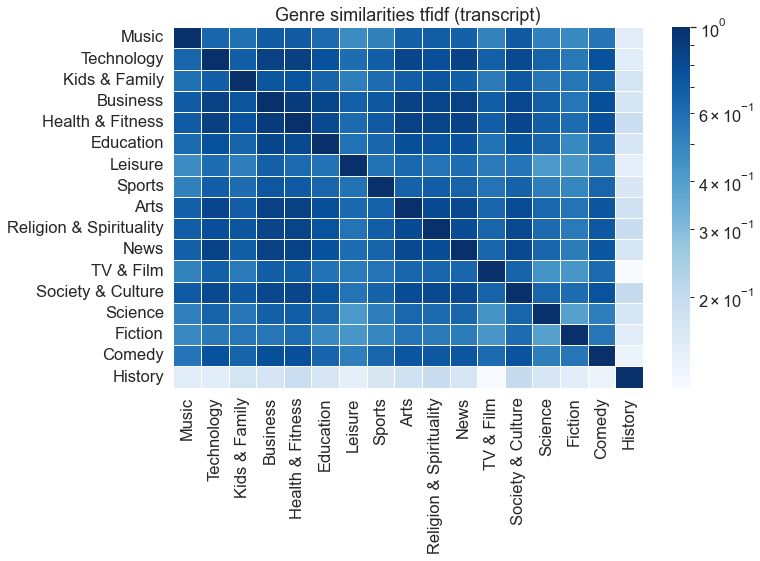

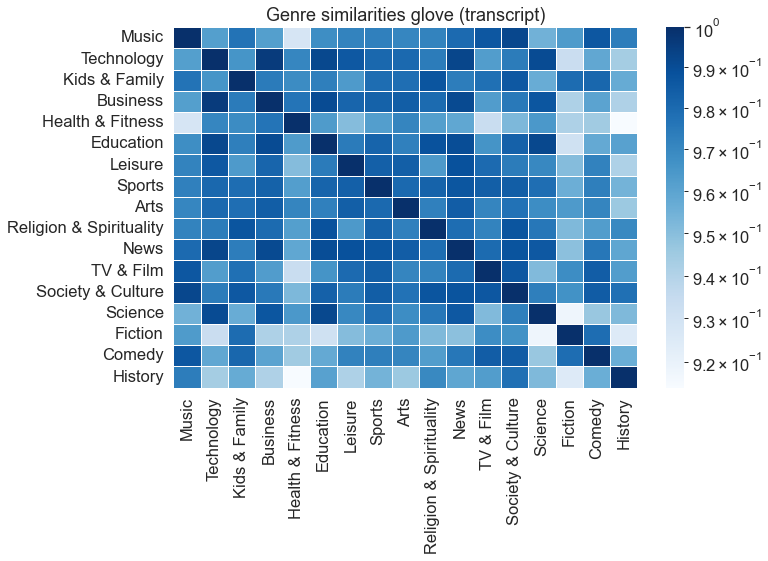

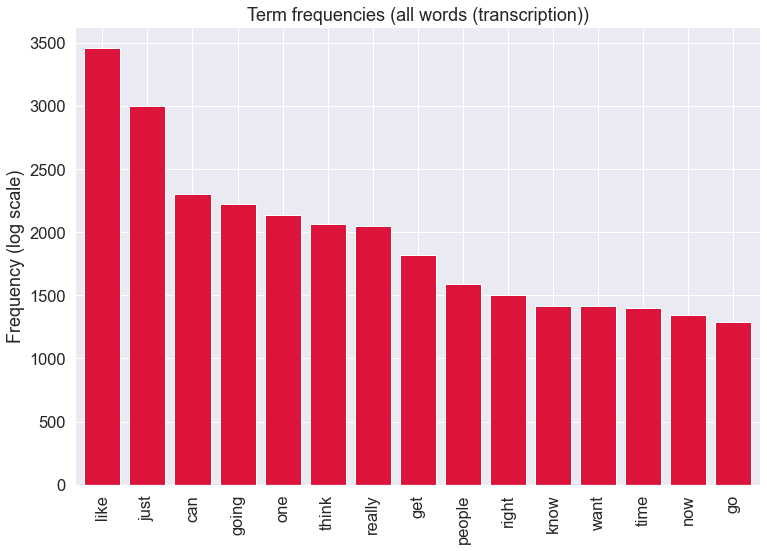

Music


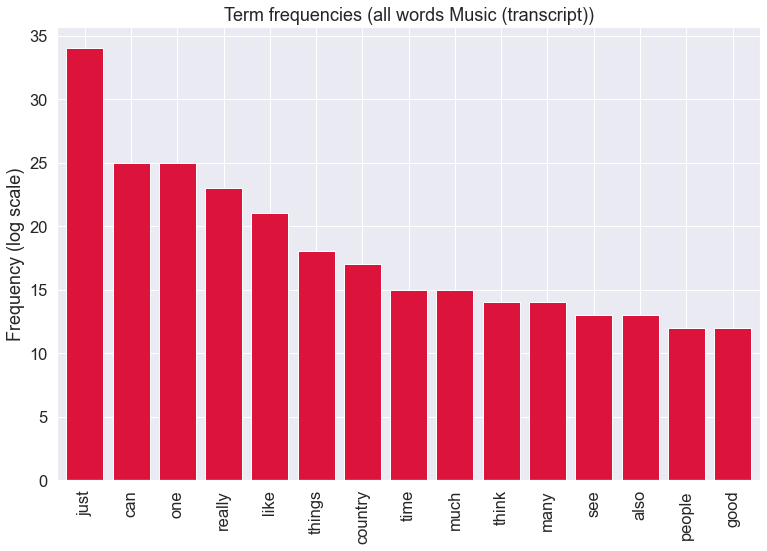

Technology


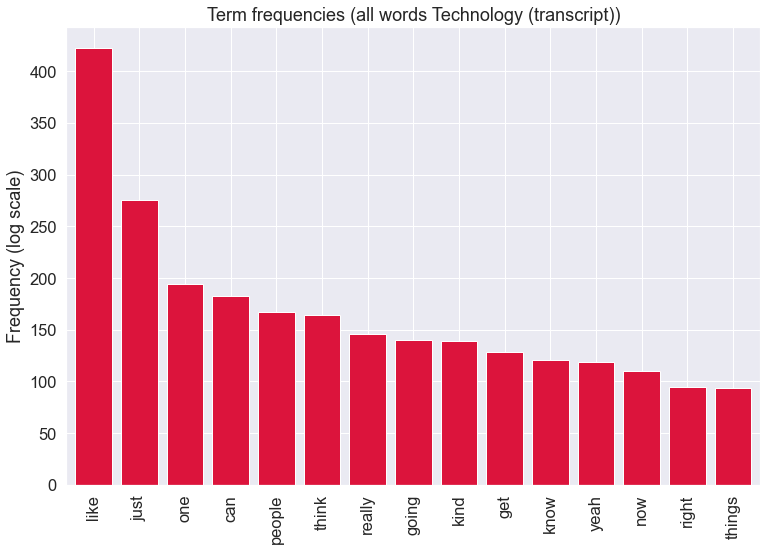

Kids & Family


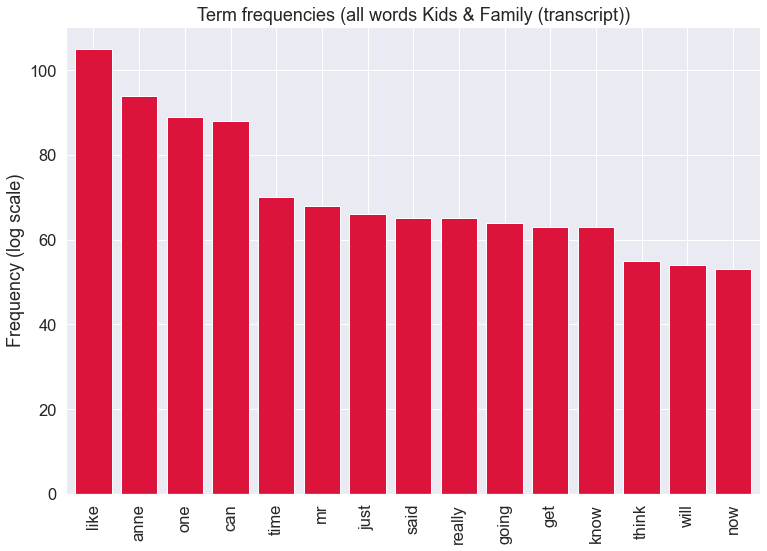

Business


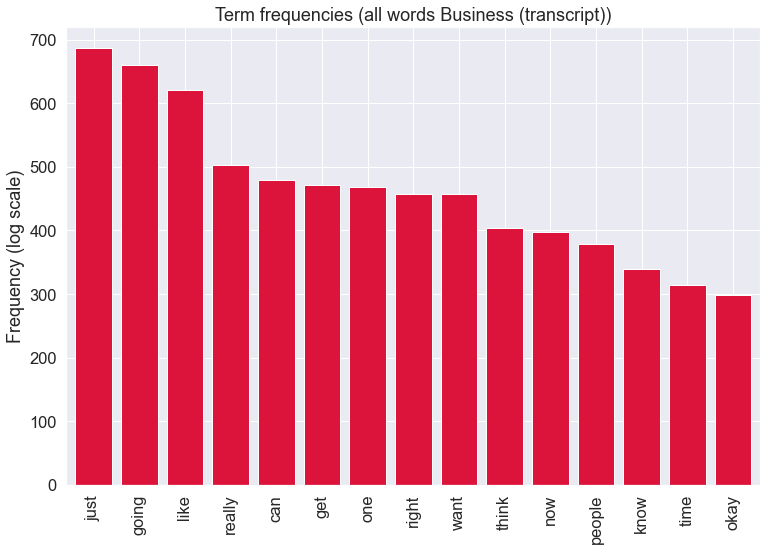

Health & Fitness


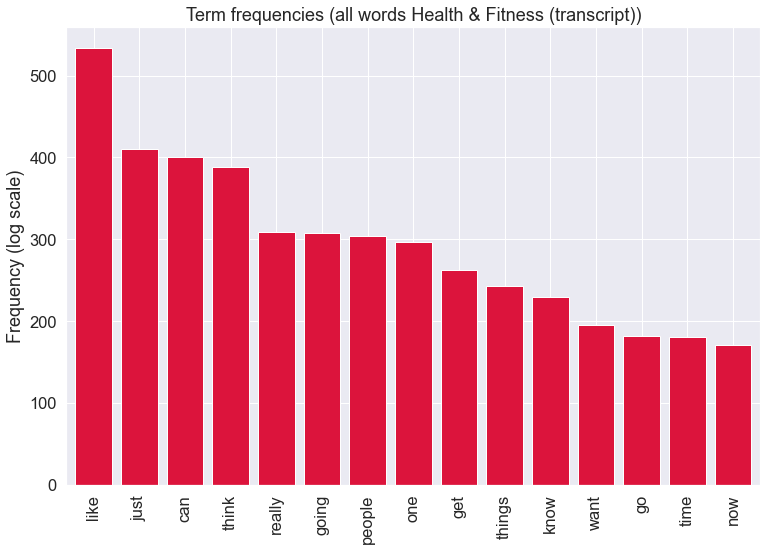

Education


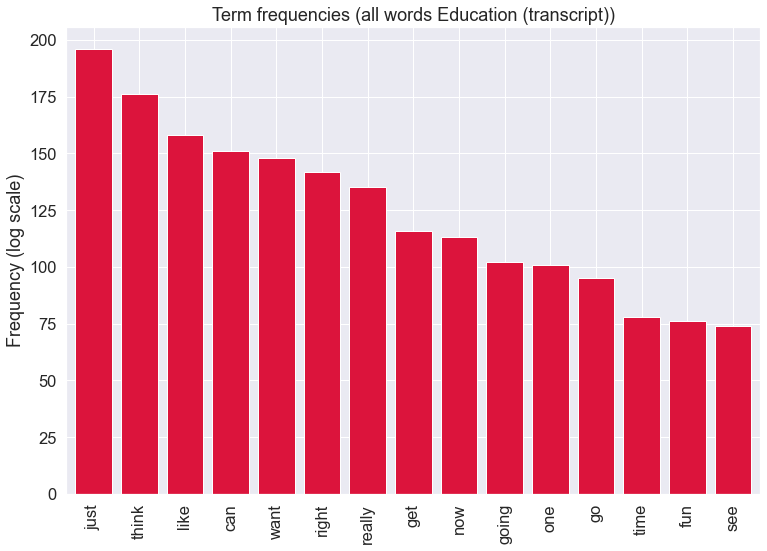

Leisure


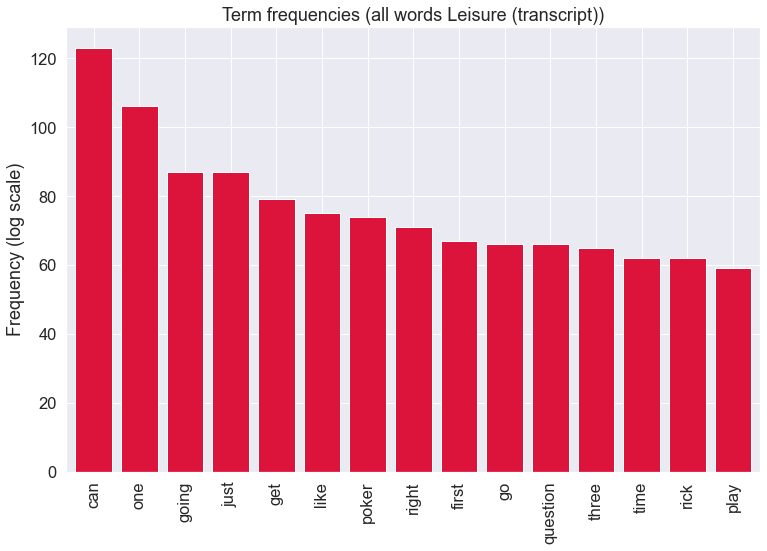

Sports


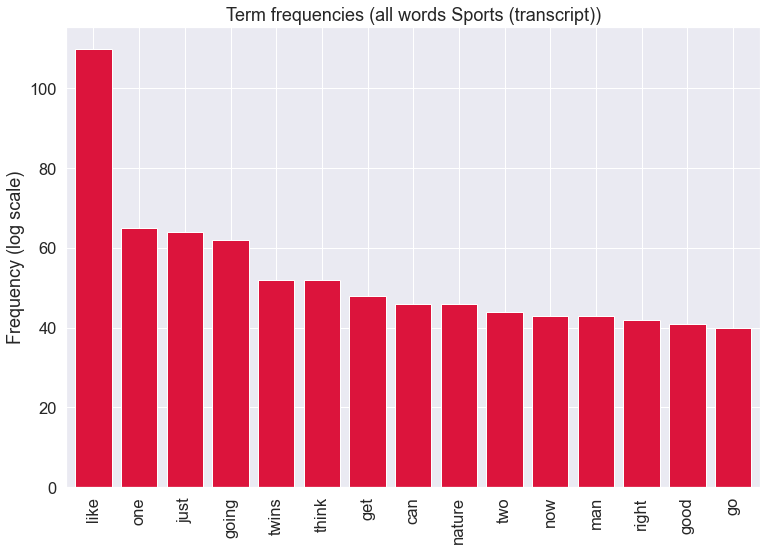

Arts


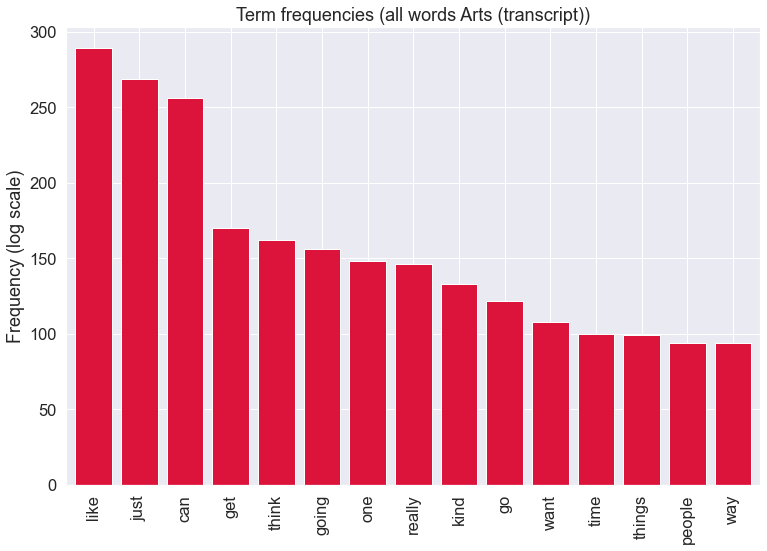

Religion & Spirituality


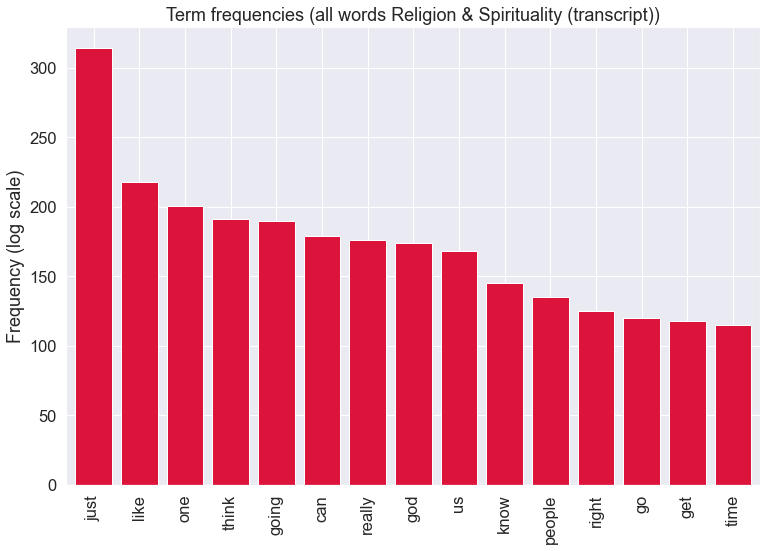

News


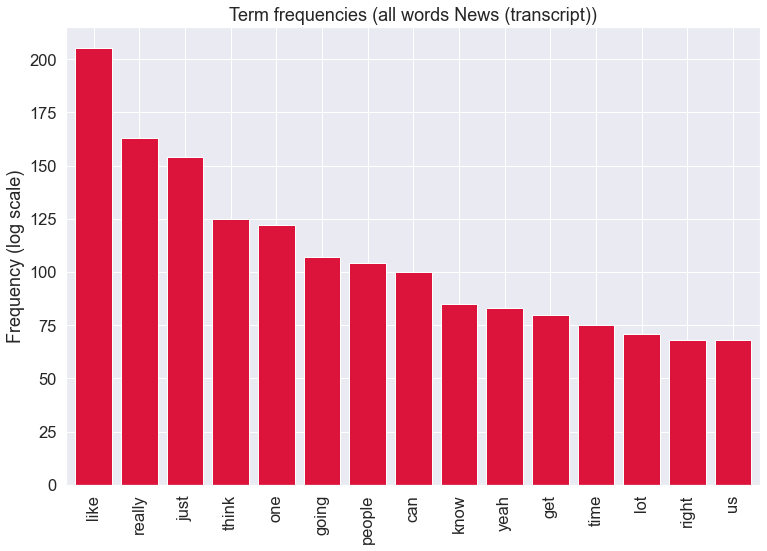

TV & Film


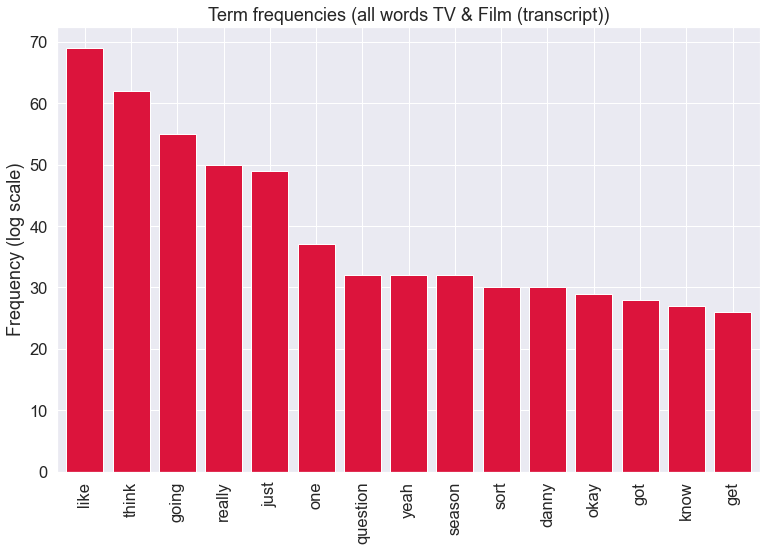

Society & Culture


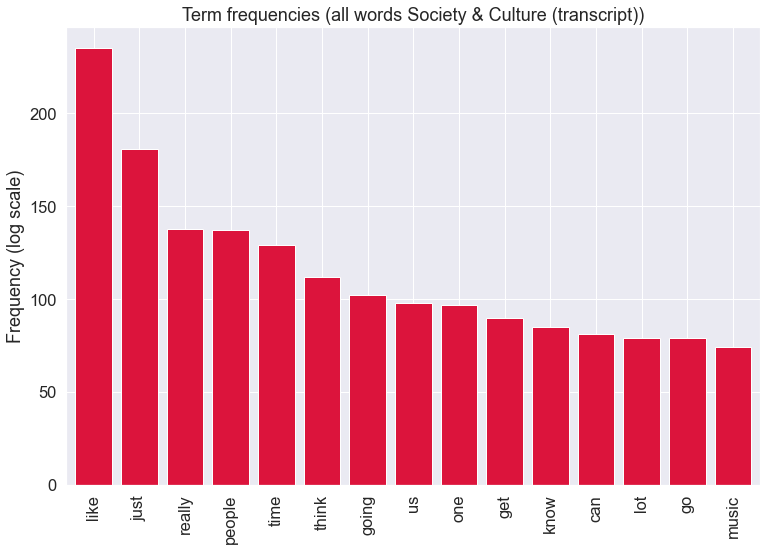

Science


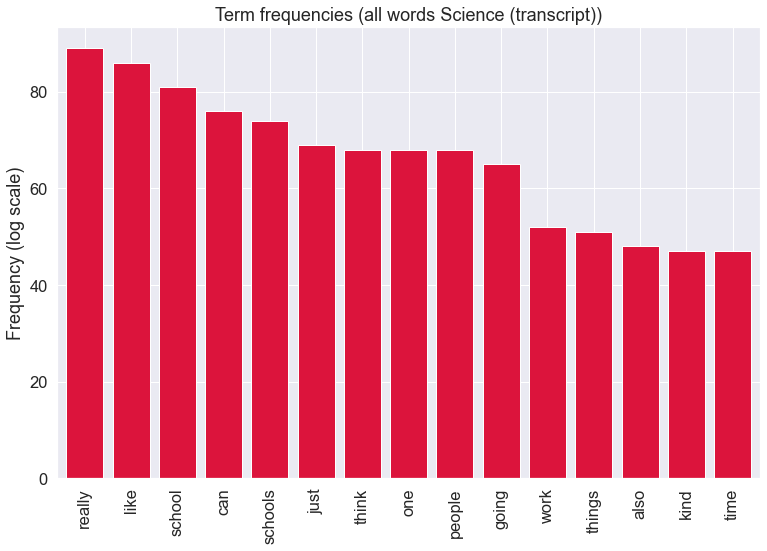

Fiction


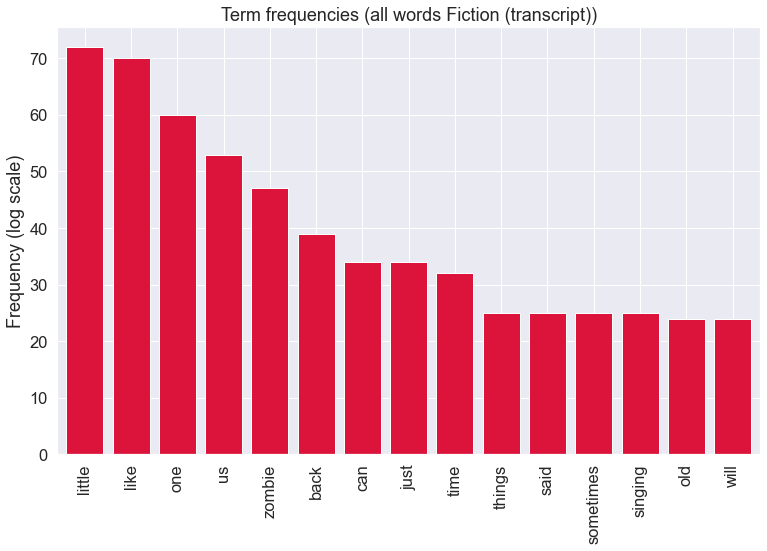

Comedy


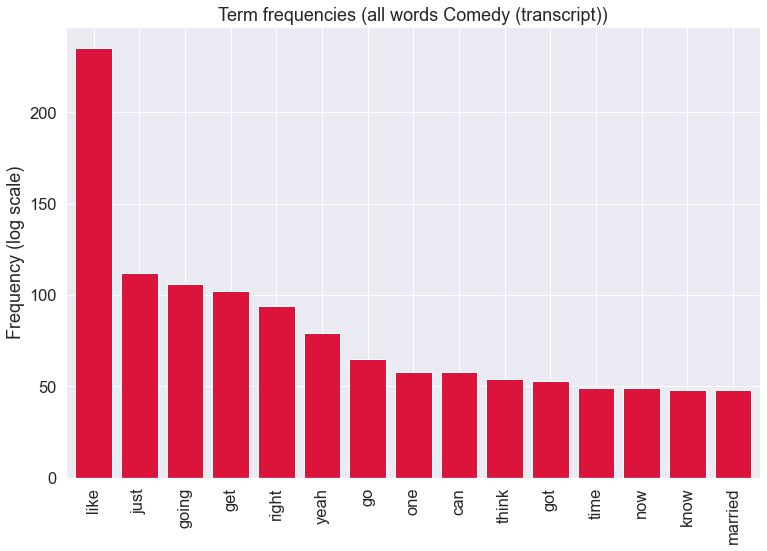

History


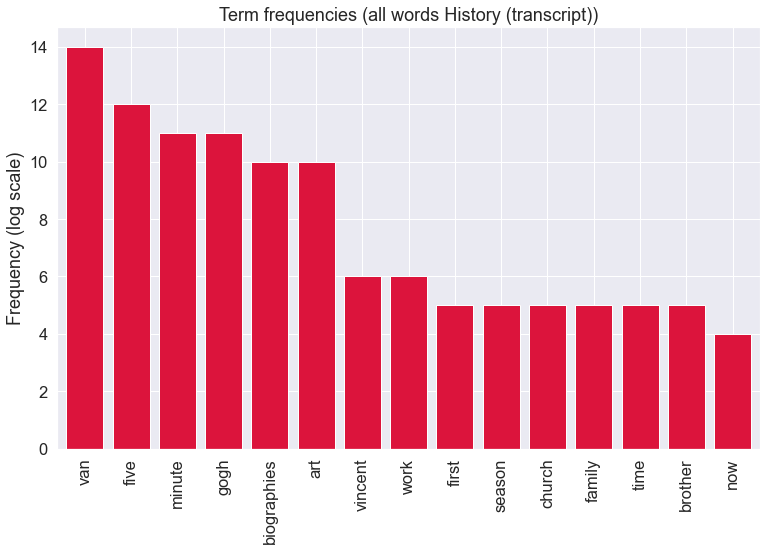

In [48]:


# Clean text of trans_df
trans_df["text_cleaned"] = full_clean(trans_df["text"])

# Heatmaps
results = genre_similarity(trans_df, textcol="text_cleaned", method="wordcount", title_spec="transcript")
results = genre_similarity(trans_df, textcol="text_cleaned", method="tfidf", title_spec="transcript")
results = genre_similarity(trans_df, textcol="text_cleaned", method="glove", title_spec="transcript", embeds=glove_embedding)



# Show most common words
most_common_words, tf = get_tf(trans_df['text_cleaned'], k=15)
plot_tf(most_common_words, tf, title_spec="all words (transcription)")

# Most commonw rod for each genre
genres = trans_df['genre'].unique()
for genre in genres:
    print(genre)
    tmp = trans_df[trans_df['genre'] == genre]
    most_common_words, tf = get_tf(tmp['text_cleaned'], k=15)
    plot_tf(most_common_words, tf, title_spec="all words {} (transcript)".format(genre))


### TODO

In [ ]:
# Bar charts naar TFIDF
# Lengte tijd podcast: distribution
# Aantal sprekers: distribution
# Hoeveel UNK
     # als unk hoeveel woorden zijn dan unk
# Onderzoeksvragen op basis van dataset
# 




# Tests etc

## Email backup
#### (TODO: move this to other file)

In [126]:


emails = ["ikwileenvisitekaartje@gmail.com", "rumbaba.001@gmail.com", "rumbaba.001+offset@gmail.com","rumbaba.001+offset2@gmail.com"]
tokens = ["7279e03a67c4407cba111129f9a089cc", "951c297210474302a1fb3070885f9fd5", "fb55882b35b14a8b881b33c6134ce30a","ae1ef303d78243d1b1313c127e5cbc7e"]


emails = {}
emails[-1] = {"email": "ikwileenvisitekaartje@gmail.com", "token": "7279e03a67c4407cba111129f9a089cc"}
emails[0] = {"email": "rumbaba.0001@gmail.com", "token": "951c297210474302a1fb3070885f9fd5"}
emails[1] = {"email": "rumbaba.001+offset0@gmail.com", "token": "0991ba6942444c94b578a4b5dc28e62b"}
emails[2] = {"email": "rumbaba.001+offset@gmail.com", "token": "fb55882b35b14a8b881b33c6134ce30a"}
emails[3] = {"email": "rumbaba.001+offset1@gmail.com", "token": "47ce24da0e8c4212893f5e4f51ab388a"}
emails[4] = {"email": "rumbaba.001+offset2@gmail.com", "token": "ae1ef303d78243d1b1313c127e5cbc7e"}


emails[5] = {"email": "rumbaba.001+offset3@gmail.com", "token": "6907d528a65f4d4e999736e12c88cb64"}
emails[6] = {"email": "rumbaba.001+offset4@gmail.com", "token": "98d218d56ac848d698cb46076f4c7457"}
emails[7] = {"email": "rumbaba.001+offset5@gmail.com", "token": "eb6dd1f6c847484086cb41513945a764"}
emails[8] = {"email": "rumbaba.001+offset6@gmail.com", "token": "4d8f049c9521441db2b541523a67d6a6"}
emails[9] = {"email": "rumbaba.001+offset7@gmail.com", "token": "9aa0c842fa334e0db392e8daf6a07626"}
emails[10] = {"email": "rumbaba.001+offset8@gmail.com", "token": "1e948614892b4ce793cffbb5dc747d4e"}

print(emails)
        
    
with open('emails.json', 'w') as fp:
    json.dump(emails, fp, indent=4, sort_keys=True)
    
    
    
    
    

{-1: {'email': 'ikwileenvisitekaartje@gmail.com', 'token': '7279e03a67c4407cba111129f9a089cc'}, 0: {'email': 'rumbaba.0001@gmail.com', 'token': '951c297210474302a1fb3070885f9fd5'}, 1: {'email': 'rumbaba.001+offset0@gmail.com', 'token': '0991ba6942444c94b578a4b5dc28e62b'}, 2: {'email': 'rumbaba.001+offset@gmail.com', 'token': 'fb55882b35b14a8b881b33c6134ce30a'}, 3: {'email': 'rumbaba.001+offset1@gmail.com', 'token': '47ce24da0e8c4212893f5e4f51ab388a'}, 4: {'email': 'rumbaba.001+offset2@gmail.com', 'token': 'ae1ef303d78243d1b1313c127e5cbc7e'}, 5: {'email': 'rumbaba.001+offset3@gmail.com', 'token': '6907d528a65f4d4e999736e12c88cb64'}, 6: {'email': 'rumbaba.001+offset4@gmail.com', 'token': '98d218d56ac848d698cb46076f4c7457'}, 7: {'email': 'rumbaba.001+offset5@gmail.com', 'token': 'eb6dd1f6c847484086cb41513945a764'}, 8: {'email': 'rumbaba.001+offset6@gmail.com', 'token': '4d8f049c9521441db2b541523a67d6a6'}, 9: {'email': 'rumbaba.001+offset7@gmail.com', 'token': '9aa0c842fa334e0db392e8daf6a0